# Memory-Optimized Advanced Feature Engineering for HAI-21.03 Dataset

This notebook implements improved feature engineering techniques for the HAI-21.03 industrial control system security dataset with memory optimization to prevent system crashes.

In [8]:
# Import required libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import gc
import psutil
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)

## 1. Memory Monitoring Functions

In [9]:
def get_memory_usage():
    """Get current memory usage in MB."""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / 1024 / 1024  # Convert to MB

def print_memory_usage(label="Current"):
    """Print current memory usage with a label."""
    memory_mb = get_memory_usage()
    print(f"{label} Memory Usage: {memory_mb:.2f} MB")
    return memory_mb

def clean_memory():
    """Force garbage collection to free memory."""
    before = get_memory_usage()
    gc.collect()
    after = get_memory_usage()
    print(f"Memory cleaned: {before-after:.2f} MB freed")

## 2. Global Variables Setup

In [10]:
# Set paths
DATA_DIR = '../hai-security-dataset/hai-21.03'
OUTPUT_DIR = '../hai-security-dataset/processed'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set parameters
CORRELATION_THRESHOLD = 0.7  # Graph edge correlation threshold
CHUNK_SIZE = 10000          # Process data in chunks to reduce memory usage
MAX_FEATURES_PER_COLUMN = 5  # Limit number of features generated per column

## 3. Memory-Efficient Data Loader

In [11]:
class MemoryEfficientHAIDataLoader:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.train_files = glob.glob(os.path.join(data_dir, 'train*.csv'))
        self.test_files = glob.glob(os.path.join(data_dir, 'test*.csv'))
        
        print(f"Found {len(self.train_files)} train files and {len(self.test_files)} test files")
    
    def _preprocess_dataframe(self, df):
        # Convert column names to lowercase for consistency
        df.columns = [col.lower() for col in df.columns]
        
        # Handle missing values
        df = df.fillna(method='ffill').fillna(method='bfill')
        
        # Ensure attack column exists (it might not in training data)
        if 'attack' not in df.columns:
            df['attack'] = 0
        
        return df
    
    def load_file(self, file_path):
        """Load a single file with memory optimization."""
        print(f"Loading {os.path.basename(file_path)}...")
        
        # Get file size
        file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f"File size: {file_size_mb:.2f} MB")
        
        # For large files, use chunking
        if file_size_mb > 100:  # If file is larger than 100MB
            print(f"Large file detected, using chunked reading")
            chunks = []
            for chunk in pd.read_csv(file_path, chunksize=CHUNK_SIZE):
                chunks.append(self._preprocess_dataframe(chunk))
                # Print memory usage periodically
                if len(chunks) % 10 == 0:
                    print_memory_usage(f"After reading {len(chunks)} chunks")
            
            # Concatenate chunks
            df = pd.concat(chunks)
            # Clear chunks to free memory
            del chunks
            gc.collect()
        else:
            # For smaller files, read directly
            df = pd.read_csv(file_path)
            df = self._preprocess_dataframe(df)
        
        print(f"Loaded {os.path.basename(file_path)}: {df.shape[0]} rows, {df.shape[1]} columns")
        print_memory_usage("After loading")
        
        return df
    
    def load_train_data(self):
        """Load training data one file at a time to manage memory."""
        train_data = {}
        
        for file in self.train_files:
            file_name = os.path.basename(file).split('.')[0]
            train_data[file_name] = self.load_file(file)
            # Force garbage collection after each file
            clean_memory()
        
        return train_data
    
    def load_test_data(self):
        """Load test data one file at a time to manage memory."""
        test_data = {}
        
        for file in self.test_files:
            file_name = os.path.basename(file).split('.')[0]
            test_data[file_name] = self.load_file(file)
            # Force garbage collection after each file
            clean_memory()
        
        return test_data
    
    def get_feature_columns(self, df):
        """Get feature columns excluding time and attack columns."""
        feature_cols = [col for col in df.columns 
                       if not col.startswith('time') and not col.startswith('attack')]
        
        return feature_cols

In [12]:
# Initialize data loader
print_memory_usage("Initial")
data_loader = MemoryEfficientHAIDataLoader(DATA_DIR)

# Load training data
train_data = data_loader.load_train_data()
print_memory_usage("After loading training data")

Initial Memory Usage: 218.11 MB
Found 3 train files and 5 test files
Loading train1.csv...
File size: 112.50 MB
Large file detected, using chunked reading
After reading 10 chunks Memory Usage: 295.39 MB
After reading 20 chunks Memory Usage: 365.42 MB
Loaded train1.csv: 216001 rows, 84 columns
After loading Memory Usage: 378.43 MB
Memory cleaned: 0.00 MB freed
Loading train2.csv...
File size: 117.68 MB
Large file detected, using chunked reading
After reading 10 chunks Memory Usage: 448.14 MB
After reading 20 chunks Memory Usage: 517.65 MB
Loaded train2.csv: 226801 rows, 84 columns
After loading Memory Usage: 533.21 MB
Memory cleaned: 0.00 MB freed
Loading train3.csv...
File size: 249.65 MB
Large file detected, using chunked reading
After reading 10 chunks Memory Usage: 607.18 MB
After reading 20 chunks Memory Usage: 677.23 MB
After reading 30 chunks Memory Usage: 747.62 MB
After reading 40 chunks Memory Usage: 817.84 MB
Loaded train3.csv: 478801 rows, 84 columns
After loading Memory Usa

867.359375

## 4. Memory-Efficient Graph Creation

In [13]:
def create_memory_efficient_graph(train_data, correlation_threshold=0.7, sample_size=10000):
    """
    Create a graph structure based on column names and their correlations with memory optimization.
    
    Args:
        train_data (dict): Dictionary of training dataframes
        correlation_threshold (float): Threshold for adding edges between components
        sample_size (int): Number of rows to sample for correlation calculation
        
    Returns:
        nx.Graph: NetworkX graph representing the system
    """
    print_memory_usage("Before graph creation")
    G = nx.Graph()
    
    # Get first dataframe to extract columns
    first_df = list(train_data.values())[0]
    cols = [col for col in first_df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Identify subsystems from column names
    subsystems = set()
    for col in cols:
        parts = col.split('_')
        if len(parts) >= 2:
            subsystems.add(parts[0])
    
    print(f"Identified subsystems: {subsystems}")
    
    # Add nodes for each subsystem
    for subsystem in subsystems:
        G.add_node(subsystem, type='subsystem')
    
    # Add nodes for each sensor/actuator
    for col in cols:
        parts = col.split('_')
        if len(parts) >= 2:
            subsystem = parts[0]
            component = '_'.join(parts[1:])
            
            # Add node for component
            G.add_node(col, type='component', subsystem=subsystem)
            
            # Add edge between component and its subsystem
            G.add_edge(subsystem, col, weight=1.0)
    
    # Calculate correlations in chunks to save memory
    print("Calculating correlations in chunks...")
    
    # Sample data for correlation calculation
    sampled_data = {}
    for name, df in train_data.items():
        if len(df) > sample_size:
            sampled_data[name] = df.sample(sample_size, random_state=42)
        else:
            sampled_data[name] = df
    
    # Merge sampled data
    merged_df = pd.concat(list(sampled_data.values()), axis=0)
    print(f"Using {len(merged_df)} rows for correlation calculation")
    
    # Clear sampled_data to free memory
    del sampled_data
    clean_memory()
    
    # Calculate correlations in batches
    batch_size = 50  # Process 50 columns at a time
    edge_count = 0
    
    for i in range(0, len(cols), batch_size):
        batch_cols = cols[i:i+batch_size]
        print(f"Processing correlation batch {i//batch_size + 1}/{(len(cols)+batch_size-1)//batch_size}")
        
        # Calculate correlation matrix for this batch
        corr_matrix = merged_df[batch_cols].corr().abs()
        
        # Add edges based on correlations
        for col1 in batch_cols:
            for col2 in cols:
                if col1 < col2 and col2 in corr_matrix.columns:
                    corr_value = corr_matrix.loc[col1, col2]
                    if corr_value > correlation_threshold:
                        G.add_edge(col1, col2, weight=corr_value)
                        edge_count += 1
        
        # Clear correlation matrix to free memory
        del corr_matrix
        clean_memory()
    
    print(f"Added {edge_count} correlation-based edges")
    
    # Add edges between subsystems based on component connections
    subsystem_connections = {}
    for subsys1 in subsystems:
        for subsys2 in subsystems:
            if subsys1 < subsys2:
                subsystem_connections[(subsys1, subsys2)] = 0
    
    # Process edges in batches to save memory
    edges = list(G.edges())
    for i in range(0, len(edges), 1000):
        batch_edges = edges[i:i+1000]
        for u, v in batch_edges:
            if G.nodes[u].get('type') == 'component' and G.nodes[v].get('type') == 'component':
                subsys_u = G.nodes[u].get('subsystem')
                subsys_v = G.nodes[v].get('subsystem')
                if subsys_u and subsys_v and subsys_u != subsys_v:
                    key = (min(subsys_u, subsys_v), max(subsys_u, subsys_v))
                    subsystem_connections[key] = subsystem_connections.get(key, 0) + 1
    
    # Add edges between subsystems
    for (subsys1, subsys2), count in subsystem_connections.items():
        if count > 0:
            G.add_edge(subsys1, subsys2, weight=count, type='subsystem_connection')
            print(f"Added edge between subsystems {subsys1} and {subsys2} with weight {count}")
    
    print_memory_usage("After graph creation")
    return G

In [14]:
# Create graph with memory optimization
G = create_memory_efficient_graph(train_data, CORRELATION_THRESHOLD)

# Print graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Count node types
node_types_count = {}
for _, data in G.nodes(data=True):
    if 'type' in data:
        node_type = data['type']
        if node_type not in node_types_count:
            node_types_count[node_type] = 0
        node_types_count[node_type] += 1

print("\nNode types:")
for node_type, count in node_types_count.items():
    print(f"  {node_type}: {count}")

Before graph creation Memory Usage: 867.45 MB
Identified subsystems: {'p2', 'p3', 'p4', 'p1'}
Calculating correlations in chunks...
Using 30000 rows for correlation calculation
Memory cleaned: 0.00 MB freed
Processing correlation batch 1/2
Memory cleaned: 0.00 MB freed
Processing correlation batch 2/2
Memory cleaned: 0.00 MB freed
Added 96 correlation-based edges
Added edge between subsystems p3 and p4 with weight 5
After graph creation Memory Usage: 890.89 MB
Number of nodes: 83
Number of edges: 176

Node types:
  subsystem: 4
  component: 79


Showing subgraph with 30 nodes and 111 edges


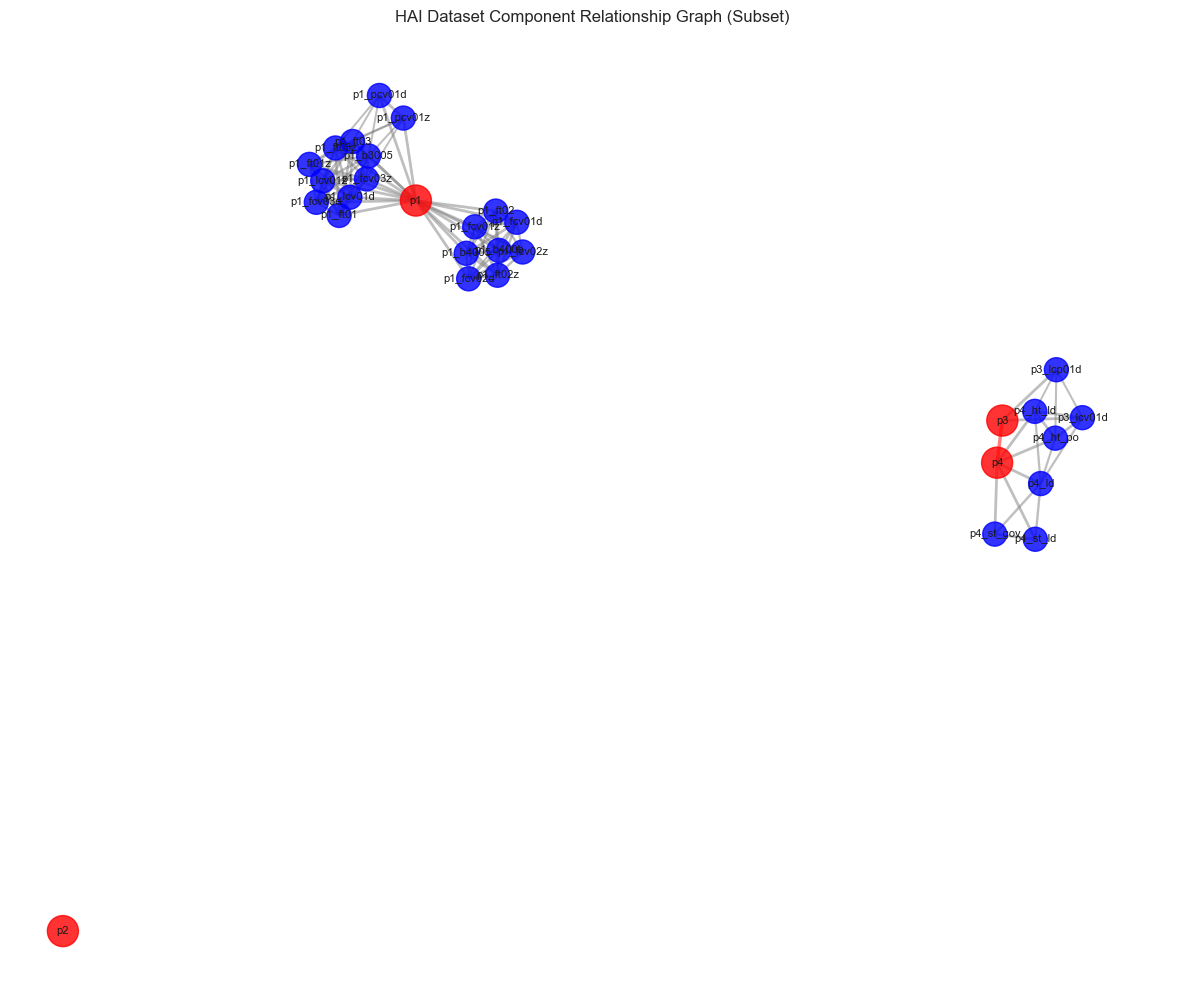

In [15]:
# Visualize a subset of the graph to save memory
def visualize_graph_subset(G, max_nodes=30):
    """
    Visualize a subset of the graph to save memory.
    
    Args:
        G (nx.Graph): NetworkX graph
        max_nodes (int): Maximum number of nodes to display
    """
    # Get the most connected nodes
    degrees = dict(G.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
    G_sub = G.subgraph(top_nodes)
    print(f"Showing subgraph with {G_sub.number_of_nodes()} nodes and {G_sub.number_of_edges()} edges")
    
    plt.figure(figsize=(12, 10))
    
    # Set node colors based on type
    node_colors = []
    node_sizes = []
    for node in G_sub.nodes():
        node_type = G_sub.nodes[node].get('type', 'unknown')
        if node_type == 'subsystem':
            node_colors.append('red')
            node_sizes.append(500)
        elif node_type == 'component':
            node_colors.append('blue')
            node_sizes.append(300)
        else:
            node_colors.append('gray')
            node_sizes.append(300)
    
    # Set edge widths and colors based on type and weight
    edge_widths = []
    edge_colors = []
    for u, v, data in G_sub.edges(data=True):
        if data.get('type') == 'subsystem_connection':
            edge_colors.append('red')
            edge_widths.append(data.get('weight', 1.0) * 0.5)
        else:
            edge_colors.append('gray')
            edge_widths.append(data.get('weight', 1.0) * 2)
    
    # Draw the graph
    pos = nx.spring_layout(G_sub, seed=42)
    nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(G_sub, pos, width=edge_widths, edge_color=edge_colors, alpha=0.5)
    nx.draw_networkx_labels(G_sub, pos, font_size=8)
    
    plt.title("HAI Dataset Component Relationship Graph (Subset)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize graph subset
visualize_graph_subset(G)

## 5. Memory-Efficient Feature Engineering

In [16]:
def extract_time_series_features_chunked(df, window_sizes=[10, 30], chunk_size=10000):
    """
    Extract time series features in chunks to save memory.
    
    Args:
        df (pd.DataFrame): Input dataframe
        window_sizes (list): List of window sizes for rolling features
        chunk_size (int): Size of chunks to process
        
    Returns:
        pd.DataFrame: DataFrame with additional time series features
    """
    print_memory_usage("Before time series feature extraction")
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Select a subset of columns to reduce memory usage
    if len(cols) > 50:
        print(f"Too many columns ({len(cols)}), selecting top 50 by variance")
        variances = df[cols].var().sort_values(ascending=False)
        cols = variances.index[:50].tolist()
    
    # Initialize result dataframe with original columns
    result_df = df.copy()
    
    # Process each window size
    for window in window_sizes:
        print(f"Processing window size {window}...")
        
        # Process each column
        for col in tqdm(cols, desc=f"Adding rolling features (window={window})"):
            # Limit features per column to save memory
            features_added = 0
            
            # Add rolling mean
            if features_added < MAX_FEATURES_PER_COLUMN:
                result_df[f"{col}_rolling_{window}_mean"] = df[col].rolling(window=window).mean()
                features_added += 1
            
            # Add rolling std
            if features_added < MAX_FEATURES_PER_COLUMN:
                result_df[f"{col}_rolling_{window}_std"] = df[col].rolling(window=window).std()
                features_added += 1
            
            # Add rolling min
            if features_added < MAX_FEATURES_PER_COLUMN:
                result_df[f"{col}_rolling_{window}_min"] = df[col].rolling(window=window).min()
                features_added += 1
            
            # Add rolling max
            if features_added < MAX_FEATURES_PER_COLUMN:
                result_df[f"{col}_rolling_{window}_max"] = df[col].rolling(window=window).max()
                features_added += 1
            
            # Add trend feature
            if features_added < MAX_FEATURES_PER_COLUMN:
                roll_mean = df[col].rolling(window=window).mean()
                result_df[f"{col}_rolling_{window}_trend"] = roll_mean.diff()
                features_added += 1
        
        # Force garbage collection after each window
        clean_memory()
    
    # Add lag features (limited to save memory)
    lag_values = [1, 5]
    for lag in lag_values:
        print(f"Adding lag features (lag={lag})...")
        for col in tqdm(cols[:20], desc=f"Adding lag features (lag={lag})"):  # Limit to 20 columns
            result_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    
    # Fill NaN values
    result_df = result_df.fillna(method='bfill').fillna(method='ffill')
    
    print_memory_usage("After time series feature extraction")
    return result_df

In [17]:
def add_graph_based_features_chunked(df, G, chunk_size=10000):
    """
    Add graph-based features in chunks to save memory.
    
    Args:
        df (pd.DataFrame): Input dataframe
        G (nx.Graph): NetworkX graph
        chunk_size (int): Size of chunks to process
        
    Returns:
        pd.DataFrame: DataFrame with additional graph-based features
    """
    print_memory_usage("Before graph-based feature extraction")
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Initialize result dataframe with original columns
    result_df = df.copy()
    
    # Identify subsystems
    subsystems = [node for node, data in G.nodes(data=True) if data.get('type') == 'subsystem']
    print(f"Processing subsystems: {subsystems}")
    
    # Add subsystem-level features
    for subsystem in subsystems:
        # Get components for this subsystem
        subsystem_components = [node for node, data in G.nodes(data=True) 
                               if data.get('type') == 'component' and data.get('subsystem') == subsystem]
        
        # Filter to components that exist in the dataframe
        subsystem_components = [comp for comp in subsystem_components if comp in df.columns]
        
        if subsystem_components:
            print(f"Processing {subsystem} with {len(subsystem_components)} components")
            
            # Limit number of components to process
            if len(subsystem_components) > 10:
                print(f"Too many components, selecting 10 with highest variance")
                variances = df[subsystem_components].var().sort_values(ascending=False)
                subsystem_components = variances.index[:10].tolist()
            
            # Calculate subsystem-level statistics
            result_df[f"{subsystem}_mean"] = df[subsystem_components].mean(axis=1)
            result_df[f"{subsystem}_std"] = df[subsystem_components].std(axis=1)
            result_df[f"{subsystem}_max"] = df[subsystem_components].max(axis=1)
            result_df[f"{subsystem}_min"] = df[subsystem_components].min(axis=1)
            
            # Calculate z-scores for selected components
            for component in subsystem_components[:5]:  # Limit to 5 components
                mean = result_df[f"{subsystem}_mean"]
                std = result_df[f"{subsystem}_std"].replace(0, 1e-10)  # Avoid division by zero
                result_df[f"{component}_zscore"] = (df[component] - mean) / std
        
        # Force garbage collection after each subsystem
        clean_memory()
    
    # Add cross-subsystem features (limited to save memory)
    processed_pairs = 0
    for i, s1 in enumerate(subsystems):
        for j, s2 in enumerate(subsystems):
            if i < j and processed_pairs < 5:  # Limit to 5 subsystem pairs
                # Check if subsystems are connected in the graph
                if G.has_edge(s1, s2):
                    print(f"Adding cross-subsystem features for {s1} and {s2}")
                    
                    # Calculate ratio and difference between subsystem means
                    if f"{s1}_mean" in result_df.columns and f"{s2}_mean" in result_df.columns:
                        s2_mean = result_df[f"{s2}_mean"].replace(0, 1e-10)  # Avoid division by zero
                        result_df[f"{s1}_{s2}_ratio"] = result_df[f"{s1}_mean"] / s2_mean
                        result_df[f"{s1}_{s2}_diff"] = result_df[f"{s1}_mean"] - result_df[f"{s2}_mean"]
                        processed_pairs += 1
    
    # Add graph centrality features (limited to save memory)
    print("Calculating graph centrality measures...")
    
    # Calculate centrality measures for a subset of nodes
    component_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'component']
    if len(component_nodes) > 50:
        print(f"Too many component nodes ({len(component_nodes)}), selecting 50 randomly")
        np.random.seed(42)
        component_nodes = np.random.choice(component_nodes, 50, replace=False).tolist()
    
    # Create subgraph with selected nodes and all subsystems
    subgraph_nodes = component_nodes + subsystems
    G_sub = G.subgraph(subgraph_nodes)
    
    # Calculate centrality measures on subgraph
    degree_centrality = nx.degree_centrality(G_sub)
    
    # Add centrality-weighted features
    for col in component_nodes:
        if col in df.columns and col in degree_centrality:
            # Weight by degree centrality
            result_df[f"{col}_degree_weighted"] = df[col] * degree_centrality.get(col, 0)
    
    # Fill NaN values
    result_df = result_df.fillna(method='bfill').fillna(method='ffill')
    
    print_memory_usage("After graph-based feature extraction")
    return result_df

In [18]:
def process_dataframe_in_chunks(df, G, chunk_size=10000):
    """
    Process a dataframe in chunks to save memory.
    
    Args:
        df (pd.DataFrame): Input dataframe
        G (nx.Graph): NetworkX graph
        chunk_size (int): Size of chunks to process
        
    Returns:
        pd.DataFrame: Processed dataframe
    """
    print(f"Processing dataframe with {df.shape[0]} rows in chunks of {chunk_size}")
    
    # If dataframe is small enough, process directly
    if len(df) <= chunk_size:
        print("Dataframe is small enough to process directly")
        # Add time series features
        df_ts = extract_time_series_features_chunked(df, window_sizes=[10, 30])
        
        # Add graph-based features
        df_processed = add_graph_based_features_chunked(df_ts, G)
        
        return df_processed
    
    # Process in chunks
    chunks = []
    for i in range(0, len(df), chunk_size):
        print(f"Processing chunk {i//chunk_size + 1}/{(len(df)+chunk_size-1)//chunk_size}")
        chunk = df.iloc[i:i+chunk_size].copy()
        
        # Add time series features
        chunk_ts = extract_time_series_features_chunked(chunk, window_sizes=[10, 30])
        
        # Add graph-based features
        chunk_processed = add_graph_based_features_chunked(chunk_ts, G)
        
        chunks.append(chunk_processed)
        
        # Force garbage collection after each chunk
        del chunk, chunk_ts
        clean_memory()
    
    # Concatenate chunks
    print("Concatenating chunks...")
    result = pd.concat(chunks)
    
    # Clear chunks to free memory
    del chunks
    clean_memory()
    
    return result

## 6. Process Training Data

In [19]:
# Process first training file as a sample
first_train_name = list(train_data.keys())[0]
first_train_df = train_data[first_train_name]

print(f"Processing {first_train_name} as a sample...")
print(f"Original shape: {first_train_df.shape}")

# Process the dataframe
processed_df = process_dataframe_in_chunks(first_train_df, G, chunk_size=CHUNK_SIZE)

print(f"Processed shape: {processed_df.shape}")
print(f"New features added: {processed_df.shape[1] - first_train_df.shape[1]}")

Processing train1 as a sample...
Original shape: (216001, 84)
Processing dataframe with 216001 rows in chunks of 10000
Processing chunk 1/22
Before time series feature extraction Memory Usage: 879.91 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 338.31it/s]


Memory cleaned: 4.45 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 326.84it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 1956.62it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 2238.33it/s]


After time series feature extraction Memory Usage: 929.22 MB
Before graph-based feature extraction Memory Usage: 929.22 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 983.75 MB
Memory cleaned: 0.00 MB freed
Processing chunk 2/22
Before time series feature extraction Memory Usage: 935.88 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 303.95it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 322.47it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2455.83it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1696.18it/s]


After time series feature extraction Memory Usage: 980.38 MB
Before graph-based feature extraction Memory Usage: 980.30 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1036.95 MB
Memory cleaned: 0.00 MB freed
Processing chunk 3/22
Before time series feature extraction Memory Usage: 990.43 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 398.07it/s]

Memory cleaned: 0.00 MB freed


Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 301.49it/s]

Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...



Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2663.05it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1732.68it/s]


After time series feature extraction Memory Usage: 1040.39 MB
Before graph-based feature extraction Memory Usage: 1040.39 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1091.27 MB
Memory cleaned: 0.00 MB freed
Processing chunk 4/22
Before time series feature extraction Memory Usage: 1045.38 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 400.89it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 328.33it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2455.03it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1515.37it/s]


After time series feature extraction Memory Usage: 1092.77 MB
Before graph-based feature extraction Memory Usage: 1092.77 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1145.31 MB
Memory cleaned: 0.00 MB freed
Processing chunk 5/22
Before time series feature extraction Memory Usage: 1099.55 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 376.03it/s]

Memory cleaned: 0.00 MB freed
Processing window size 30...



Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 340.15it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 1249.83it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1451.27it/s]


After time series feature extraction Memory Usage: 1144.29 MB
Before graph-based feature extraction Memory Usage: 1144.29 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1199.70 MB
Memory cleaned: 0.00 MB freed
Processing chunk 6/22
Before time series feature extraction Memory Usage: 1154.08 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 393.47it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 320.27it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2181.24it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 2267.50it/s]


After time series feature extraction Memory Usage: 1205.77 MB
Before graph-based feature extraction Memory Usage: 1205.77 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1254.06 MB
Memory cleaned: 0.00 MB freed
Processing chunk 7/22
Before time series feature extraction Memory Usage: 1209.12 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 345.32it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 272.74it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2449.66it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 2506.16it/s]


After time series feature extraction Memory Usage: 1258.56 MB
Before graph-based feature extraction Memory Usage: 1258.56 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1308.21 MB
Memory cleaned: 0.00 MB freed
Processing chunk 8/22
Before time series feature extraction Memory Usage: 1263.81 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 190.69it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 336.15it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2203.64it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 2269.95it/s]


After time series feature extraction Memory Usage: 1311.67 MB
Before graph-based feature extraction Memory Usage: 1311.67 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1361.94 MB
Memory cleaned: 0.00 MB freed
Processing chunk 9/22
Before time series feature extraction Memory Usage: 1317.72 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 321.92it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 312.50it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2380.90it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1609.05it/s]


After time series feature extraction Memory Usage: 1363.21 MB
Before graph-based feature extraction Memory Usage: 1363.21 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1415.79 MB
Memory cleaned: 0.00 MB freed
Processing chunk 10/22
Before time series feature extraction Memory Usage: 1372.27 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 302.33it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 304.99it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 1972.31it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1596.92it/s]


After time series feature extraction Memory Usage: 1415.72 MB
Before graph-based feature extraction Memory Usage: 1415.72 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1470.09 MB
Memory cleaned: 0.00 MB freed
Processing chunk 11/22
Before time series feature extraction Memory Usage: 1427.16 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 316.76it/s]

Memory cleaned: 0.00 MB freed
Processing window size 30...



Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 304.74it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 1835.50it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1499.55it/s]


After time series feature extraction Memory Usage: 1479.51 MB
Before graph-based feature extraction Memory Usage: 1479.51 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1524.11 MB
Memory cleaned: 0.00 MB freed
Processing chunk 12/22
Before time series feature extraction Memory Usage: 1481.53 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 328.27it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 288.14it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2502.87it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1485.34it/s]


After time series feature extraction Memory Usage: 1532.55 MB
Before graph-based feature extraction Memory Usage: 1532.55 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1593.16 MB
Memory cleaned: 0.00 MB freed
Processing chunk 13/22
Before time series feature extraction Memory Usage: 1536.23 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 357.76it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 277.63it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2097.78it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1596.77it/s]


After time series feature extraction Memory Usage: 1583.36 MB
Before graph-based feature extraction Memory Usage: 1583.27 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1646.47 MB
Memory cleaned: 0.00 MB freed
Processing chunk 14/22
Before time series feature extraction Memory Usage: 1590.30 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 297.31it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 312.63it/s]

Memory cleaned: 0.00 MB freed


Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 784.80it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1529.90it/s]


After time series feature extraction Memory Usage: 1645.24 MB
Before graph-based feature extraction Memory Usage: 1645.16 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1700.99 MB
Memory cleaned: 0.00 MB freed
Processing chunk 15/22
Before time series feature extraction Memory Usage: 1644.82 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 339.52it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 288.71it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2381.44it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1627.50it/s]


After time series feature extraction Memory Usage: 1700.80 MB
Before graph-based feature extraction Memory Usage: 1700.80 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1755.48 MB
Memory cleaned: 0.00 MB freed
Processing chunk 16/22
Before time series feature extraction Memory Usage: 1699.62 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 331.30it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 307.25it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2175.53it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1527.31it/s]


After time series feature extraction Memory Usage: 1756.27 MB
Before graph-based feature extraction Memory Usage: 1756.27 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1810.27 MB
Memory cleaned: 0.00 MB freed
Processing chunk 17/22
Before time series feature extraction Memory Usage: 1754.06 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 259.62it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 284.94it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2660.01it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1610.72it/s]


After time series feature extraction Memory Usage: 1801.01 MB
Before graph-based feature extraction Memory Usage: 1801.01 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1865.22 MB
Memory cleaned: 0.00 MB freed
Processing chunk 18/22
Before time series feature extraction Memory Usage: 1808.69 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 347.99it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 213.77it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2019.16it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1599.38it/s]


After time series feature extraction Memory Usage: 1883.44 MB
Before graph-based feature extraction Memory Usage: 1883.44 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1920.33 MB
Memory cleaned: 0.00 MB freed
Processing chunk 19/22
Before time series feature extraction Memory Usage: 1863.11 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 377.46it/s]

Memory cleaned: 0.00 MB freed
Processing window size 30...



Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 301.06it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2189.78it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1781.02it/s]


After time series feature extraction Memory Usage: 1916.11 MB
Before graph-based feature extraction Memory Usage: 1916.11 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 1974.31 MB
Memory cleaned: 0.00 MB freed
Processing chunk 20/22
Before time series feature extraction Memory Usage: 1916.51 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 342.50it/s]

Memory cleaned: 0.00 MB freed
Processing window size 30...



Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 322.15it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2020.72it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1814.81it/s]


After time series feature extraction Memory Usage: 1975.08 MB
Before graph-based feature extraction Memory Usage: 1974.47 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 2029.02 MB
Memory cleaned: 0.00 MB freed
Processing chunk 21/22
Before time series feature extraction Memory Usage: 1972.10 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 336.02it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 289.00it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 1774.43it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1003.75it/s]


After time series feature extraction Memory Usage: 2029.76 MB
Before graph-based feature extraction Memory Usage: 2029.76 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 2082.79 MB
Memory cleaned: 0.00 MB freed
Processing chunk 22/22
Before time series feature extraction Memory Usage: 2022.53 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 319.40it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 348.72it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 1705.66it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1905.16it/s]


After time series feature extraction Memory Usage: 2057.55 MB
Before graph-based feature extraction Memory Usage: 2057.55 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 2095.86 MB
Memory cleaned: 0.00 MB freed
Concatenating chunks...
Memory cleaned: 0.00 MB freed
Processed shape: (216001, 822)
New features added: 738


In [20]:
# Save processed sample
output_path = os.path.join(OUTPUT_DIR, f"{first_train_name}_processed_enhanced_v2.csv")
processed_df.to_csv(output_path, index=False)
print(f"Saved processed sample to {output_path}")
clean_memory()

Saved processed sample to ../hai-security-dataset/processed\train1_processed_enhanced_v2.csv
Memory cleaned: 0.00 MB freed


## 7. Process Test Data

In [21]:
# Load and process test data
print("Loading test data...")
test_data = data_loader.load_test_data()
print_memory_usage("After loading test data")

# Process first test file as a sample
first_test_name = list(test_data.keys())[0]
first_test_df = test_data[first_test_name]

print(f"Processing {first_test_name} as a sample...")
print(f"Original shape: {first_test_df.shape}")

# Process the dataframe
processed_test_df = process_dataframe_in_chunks(first_test_df, G, chunk_size=CHUNK_SIZE)

print(f"Processed shape: {processed_test_df.shape}")
print(f"New features added: {processed_test_df.shape[1] - first_test_df.shape[1]}")

Loading test data...
Loading test1.csv...
File size: 22.67 MB
Loaded test1.csv: 43201 rows, 84 columns
After loading Memory Usage: 2286.59 MB
Memory cleaned: 0.00 MB freed
Loading test2.csv...
File size: 61.86 MB
Loaded test2.csv: 118801 rows, 84 columns
After loading Memory Usage: 2400.12 MB
Memory cleaned: 0.00 MB freed
Loading test3.csv...
File size: 56.33 MB
Loaded test3.csv: 108001 rows, 84 columns
After loading Memory Usage: 2472.21 MB
Memory cleaned: 0.00 MB freed
Loading test4.csv...
File size: 20.60 MB
Loaded test4.csv: 39601 rows, 84 columns
After loading Memory Usage: 2499.09 MB
Memory cleaned: 0.00 MB freed
Loading test5.csv...
File size: 48.10 MB
Loaded test5.csv: 92401 rows, 84 columns
After loading Memory Usage: 2528.46 MB
Memory cleaned: 0.00 MB freed
After loading test data Memory Usage: 2528.46 MB
Processing test1 as a sample...
Original shape: (43201, 84)
Processing dataframe with 43201 rows in chunks of 10000
Processing chunk 1/5
Before time series feature extractio

Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 346.13it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 317.51it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2725.70it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1446.51it/s]


After time series feature extraction Memory Usage: 2632.89 MB
Before graph-based feature extraction Memory Usage: 2631.59 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 2672.43 MB
Memory cleaned: 0.00 MB freed
Processing chunk 2/5
Before time series feature extraction Memory Usage: 2624.65 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 342.75it/s]

Memory cleaned: 0.00 MB freed
Processing window size 30...



Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 329.01it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2150.98it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1680.81it/s]


After time series feature extraction Memory Usage: 2681.54 MB
Before graph-based feature extraction Memory Usage: 2680.47 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 2720.89 MB
Memory cleaned: 0.00 MB freed
Processing chunk 3/5
Before time series feature extraction Memory Usage: 2673.20 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 304.20it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 279.84it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2108.38it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1528.29it/s]


After time series feature extraction Memory Usage: 2728.33 MB
Before graph-based feature extraction Memory Usage: 2727.26 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 2768.68 MB
Memory cleaned: 0.00 MB freed
Processing chunk 4/5
Before time series feature extraction Memory Usage: 2698.71 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 350.96it/s]


Memory cleaned: 0.00 MB freed
Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 309.57it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2348.83it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1185.80it/s]


After time series feature extraction Memory Usage: 2750.89 MB
Before graph-based feature extraction Memory Usage: 2750.89 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 2820.97 MB
Memory cleaned: 0.00 MB freed
Processing chunk 5/5
Before time series feature extraction Memory Usage: 2748.00 MB
Too many columns (79), selecting top 50 by variance
Processing window size 10...


Adding rolling features (window=10): 100%|██████████| 50/50 [00:00<00:00, 392.29it/s]

Memory cleaned: 0.00 MB freed


Processing window size 30...


Adding rolling features (window=30): 100%|██████████| 50/50 [00:00<00:00, 422.48it/s]


Memory cleaned: 0.00 MB freed
Adding lag features (lag=1)...


Adding lag features (lag=1): 100%|██████████| 20/20 [00:00<00:00, 2437.77it/s]


Adding lag features (lag=5)...


Adding lag features (lag=5): 100%|██████████| 20/20 [00:00<00:00, 1915.95it/s]


After time series feature extraction Memory Usage: 2788.91 MB
Before graph-based feature extraction Memory Usage: 2788.91 MB
Processing subsystems: ['p2', 'p3', 'p4', 'p1']
Processing p2 with 22 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p3 with 7 components
Memory cleaned: 0.00 MB freed
Processing p4 with 12 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Processing p1 with 38 components
Too many components, selecting 10 with highest variance
Memory cleaned: 0.00 MB freed
Adding cross-subsystem features for p3 and p4
Calculating graph centrality measures...
Too many component nodes (79), selecting 50 randomly
After graph-based feature extraction Memory Usage: 2803.62 MB
Memory cleaned: 0.00 MB freed
Concatenating chunks...
Memory cleaned: 0.00 MB freed
Processed shape: (43201, 788)
New features added: 704


In [22]:
# Save processed test sample
output_path = os.path.join(OUTPUT_DIR, f"{first_test_name}_processed_enhanced_v2.csv")
processed_test_df.to_csv(output_path, index=False)
print(f"Saved processed test sample to {output_path}")
clean_memory()

Saved processed test sample to ../hai-security-dataset/processed\test1_processed_enhanced_v2.csv
Memory cleaned: 0.00 MB freed


## 8. Save Graph

In [23]:
# Save graph
import pickle
with open(os.path.join(OUTPUT_DIR, 'enhanced_graph_v2.pkl'), 'wb') as f:
    pickle.dump(G, f)
print(f"Saved enhanced graph to {os.path.join(OUTPUT_DIR, 'enhanced_graph_v2.pkl')}")

Saved enhanced graph to ../hai-security-dataset/processed\enhanced_graph_v2.pkl


## 9. Memory-Efficient Processing Function for All Files

In [24]:
def process_all_files(data_dir, output_dir, graph, chunk_size=10000):
    """
    Process all files in a memory-efficient way.
    
    Args:
        data_dir (str): Directory containing data files
        output_dir (str): Directory to save processed files
        graph (nx.Graph): NetworkX graph
        chunk_size (int): Size of chunks to process
    """
    # Create data loader
    data_loader = MemoryEfficientHAIDataLoader(data_dir)
    
    # Get list of files
    train_files = data_loader.train_files
    test_files = data_loader.test_files
    
    # Process each file individually
    for file_path in train_files + test_files:
        file_name = os.path.basename(file_path).split('.')[0]
        output_path = os.path.join(output_dir, f"{file_name}_processed_enhanced_v2.csv")
        
        # Skip if already processed
        if os.path.exists(output_path):
            print(f"Skipping {file_name}, already processed")
            continue
        
        print(f"\nProcessing {file_name}...")
        
        # Load file
        df = data_loader.load_file(file_path)
        
        # Process file
        processed_df = process_dataframe_in_chunks(df, graph, chunk_size=chunk_size)
        
        # Save processed file
        processed_df.to_csv(output_path, index=False)
        print(f"Saved processed file to {output_path}")
        
        # Clear memory
        del df, processed_df
        clean_memory()

In [25]:
# This cell can be used to process all files
# Uncomment to run (may take a long time)

# process_all_files(DATA_DIR, OUTPUT_DIR, G, chunk_size=CHUNK_SIZE)

## 10. Memory Usage Summary

In [26]:
# Print final memory usage
print_memory_usage("Final")

# Print memory optimization summary
print("\nMemory Optimization Summary:")
print("1. Chunked data loading to avoid loading entire datasets at once")
print("2. Processing data in smaller chunks to reduce peak memory usage")
print("3. Limiting the number of features generated per column")
print("4. Using subsampling for correlation calculations")
print("5. Calculating graph centrality measures on subgraphs")
print("6. Regular garbage collection to free unused memory")
print("7. Processing files individually instead of all at once")

Final Memory Usage: 2842.41 MB

Memory Optimization Summary:
1. Chunked data loading to avoid loading entire datasets at once
2. Processing data in smaller chunks to reduce peak memory usage
3. Limiting the number of features generated per column
4. Using subsampling for correlation calculations
5. Calculating graph centrality measures on subgraphs
6. Regular garbage collection to free unused memory
7. Processing files individually instead of all at once
